В файле 'test_3.csv' лежит результат теста -  рассылки email, целевая метрика - конверсия в переход на сайт с этого email. 
Рассмотрим таблицу и выясним увеличилась ли конверсия.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data=pd.read_csv('test_3.csv')

In [3]:
data.tail()

,group,client_id,click_flg
20028,control,20029,0
20029,control,20030,1
20030,control,20031,1
20031,control,20032,0
20032,control,20033,0


In [4]:
#Поделим на подвыборки и посмотрим на каждую в отдельности:
data.groupby("group").agg({'client_id':'count'})

,client_id
group,
control,10010
test,10023


In [5]:
B=data[0:10023]
A=data[10023::]
A.head()

,group,client_id,click_flg
10023,control,10024,0
10024,control,10025,0
10025,control,10026,0
10026,control,10027,0
10027,control,10028,0


In [6]:
A.groupby("click_flg").agg({'client_id':'count'})

,client_id
click_flg,
0,6883
1,3127


In [7]:
B.groupby("click_flg").agg({'client_id':'count'})

,client_id
click_flg,
0,7061
1,2962


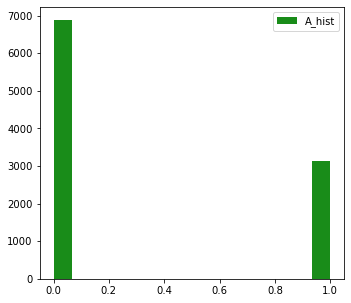

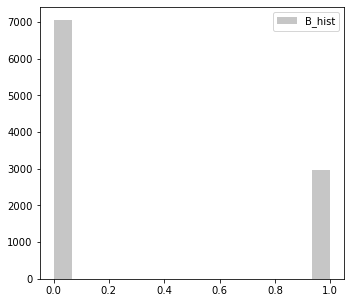

In [8]:
#Видим, что после рассылки число посетивших сайт уменьшилось, несмотря на то что в подвыборке B клиентов больше.
#Проверим на критериях  саму конверсию:
# распределения у нашей выборки - Бернулли:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(A['click_flg'],
           bins = 15,
           color = 'g',
           alpha = 0.9,
           label = 'A_hist')
pylab.legend()

pylab.figure(figsize(12, 5))
pylab.subplot(1,2,2)
pylab.hist(B['click_flg'],
           bins = 15,
           color = 'silver',
           alpha = 0.9,
           label = 'B_hist')
pylab.legend()
pylab.show()


In [9]:
#Можно воспользоваться критерием Хи-квадрат Пирсона. H_0="конверсия не изменилась", H_1="изменилась"
Atable = pd.crosstab(
    data['group'],
    data['click_flg'],
    margins = True
)
Atable
Btable = pd.crosstab(
    data['group'],
    data['click_flg']
)
Atable

click_flg,0,1,All
group,,,
control,6883,3127,10010
test,7061,2962,10023
All,13944,6089,20033


In [10]:
expected = []
obs1 = np.append(Atable.iloc[0][0:2].values, Atable.iloc[1][0:2].values) #6883 3127, 7061, 2962
rows = Atable.iloc[0:2,2].values #[10010, 10023] 
cols = Atable.iloc[2,0:2].values 
total = Atable.loc['All','All'] #20033
for count in range(2):
    for column in cols:
        expected.append((rows[count]*column)/total) # Ожидаемые частоты column/total - доля купивших во всей выборке
obs = obs1 + 0.5 * np.sign(expected - obs1) 
X=sum(((obs - expected)**2)/expected)
print("статистика Хи^2", X)

статистика Хи^2 6.65548520025077


In [11]:
#Найдем p-value
p_value =  1- stats.chi2.cdf(X,1)

if p_value > 0.05:
    print('Не можем отвергнуть нулевую гипотезу о том, что доли не имеют значимого различия', '\nХи-квадрат критерий=',X,'\np-value = ',p_value)
else:
    print('Не можем принять нулевую гипотезу о том, что доли не имеют значимого различия','\nХи-квадрат критерий=',X,'\np-value = ',p_value)

Не можем принять нулевую гипотезу о том, что доли не имеют значимого различия 
Хи-квадрат критерий= 6.65548520025077 
p-value =  0.009885105063293764


In [16]:
#Конверсия изменилась. Проверим, что дейтствительно уменьшилась по критерию Манна_Уитни:
new=data.sort_values('click_flg')
new['rank']=new['click_flg'].rank(ascending = True, numeric_only = True)
new.head(10)

,group,client_id,click_flg,rank
20032,control,20033,0,6972.5
10014,test,10015,0,6972.5
10015,test,10016,0,6972.5
20031,control,20032,0,6972.5
10017,test,10018,0,6972.5
17072,control,17073,0,6972.5
10019,test,10020,0,6972.5
10020,test,10021,0,6972.5
10021,test,10022,0,6972.5
17071,control,17072,0,6972.5


In [17]:
rank_sum=new.groupby('group')['rank'].sum()
rank_sum

group
control    101116320.5
test        99554240.5
Name: rank, dtype: float64

In [19]:
# разделяем обратно на 2 выборки
Anew = new[new['group'] == 'control']['click_flg']
Bnew = new[new['group'] == 'test']['click_flg']
Arank = new[new['group'] == 'control']['rank'].sum()
Brank = new[new['group'] == 'test']['rank'].sum()

In [20]:
#Вычислим статистику критерия U:
n1=Anew.count()
n2=Bnew.count()
N = n1 * n2 #N1*N2
max_rank = max(Arank,Brank) 
max_count = float() 
if Arank > Brank:
    max_count = n1
    print("A")
else:
    max_count = n2
    print("B")
U=N + (max_count * (max_count + 1))/2 - max_rank
U

A


49318964.5

In [21]:
#Найдем z и p-value
m_u = n1*n2/2 
sigma = sqrt((n1*n2)*(n1+n2+1)/12)
z= (U - m_u)/sigma
p_value = stats.norm.cdf(z) 
if p_value > 0.05:
    print('Нет статистически значимой разницы и оснований отвергнуть гипотезу H0','\nU-критерий:',U,
              '\nz_score',z,'\np-value',round(p,4))
else:
    print('Есть статистически значимая разница, гипотеза H0 отвергается','\nU-критерий:',U,
              '\nz_score',z,'\np-value',round(p_value,4))

      


Есть статистически значимая разница, гипотеза H0 отвергается 
U-критерий: 49318964.5 
z_score nan 
p-value nan


<ipython-input-21-eab7ed768a17>:3: RuntimeWarning: overflow encountered in long_scalars
  sigma = sqrt((n1*n2)*(n1+n2+1)/12)
<ipython-input-21-eab7ed768a17>:3: RuntimeWarning: invalid value encountered in sqrt
  sigma = sqrt((n1*n2)*(n1+n2+1)/12)


In [ ]:
#У А ранг больше => конверсия уменьшилась.